# Imports
---

In [211]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, make_scorer, recall_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle

# Data Loading, Exploration and Preprocessing
---

In [130]:
cols = ['Flyer_Miles/Year', 'Percent_Time_Gaming', 'IceCream_Liters/Week', 'Class']

In [131]:
train_dating = pd.read_csv(filepath_or_buffer="./datingData_training.txt", sep="\t", names=cols)
test_dating = pd.read_csv(filepath_or_buffer="./datingData_test.txt", sep="\t", names=cols)

train_dating_X = train_dating.iloc[:,-2::-1]
train_dating_Y = train_dating.iloc[:,-1]
test_dating_X = test_dating.iloc[:,-2::-1]
test_dating_Y = test_dating.iloc[:,-1]

# dating_X = pd.concat([train_dating_X, test_dating_X], axis=0)
# dating_Y = pd.concat([train_dating_Y, test_dating_Y], axis=0)

dating_X = train_dating_X
dating_Y = train_dating_Y

In [132]:
display(dating_X.head())
display(dating_Y.head())

,IceCream_Liters/Week,Percent_Time_Gaming,Flyer_Miles/Year
0,0.953952,8.326976,40920
1,1.673904,7.153469,14488
2,0.805124,1.441871,26052
3,0.428964,13.147394,75136
4,0.134296,1.669788,38344


0    largeDoses
1    smallDoses
2     didntLike
3     didntLike
4     didntLike
Name: Class, dtype: object

### Label Encoding and Standardizing

In [133]:
standard_scaler = StandardScaler()
label_encoder = LabelEncoder()

dating_X = pd.DataFrame(standard_scaler.fit_transform(dating_X), columns=cols[:len(cols)-1])
dating_Y = pd.Series(label_encoder.fit_transform(dating_Y), name='class')

test_dating_X = pd.DataFrame(standard_scaler.fit_transform(test_dating_X), columns=cols[:len(cols)-1])
test_dating_Y = pd.Series(label_encoder.fit_transform(test_dating_Y), name='class')

display(dating_X.head())
display(dating_Y.head())
display(dating_Y.value_counts().head())

,Flyer_Miles/Year,Percent_Time_Gaming,IceCream_Liters/Week
0,0.270115,0.404833,0.297354
1,1.747063,0.127640,-0.916683
2,-0.035199,-1.221490,-0.385542
3,-0.806873,1.543459,1.868916
4,-1.411371,-1.167654,0.179037


0    1
1    2
2    0
3    0
4    0
Name: class, dtype: int64

class
0    220
1    200
2    180
Name: count, dtype: int64

### Visualizing feature distributions

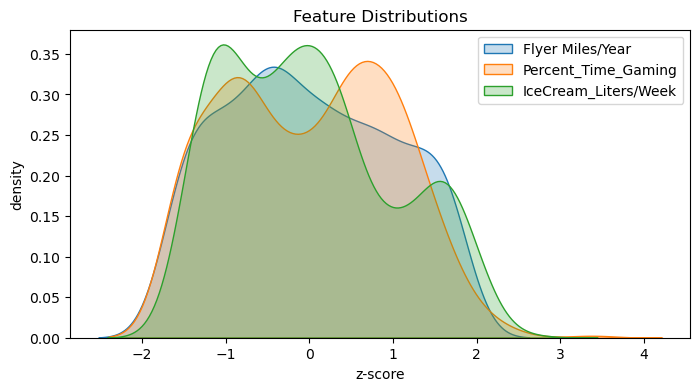

In [134]:
plt.figure(figsize=(8,4))

sns.kdeplot(dating_X['Flyer_Miles/Year'], fill=True, label='Flyer Miles/Year')
sns.kdeplot(dating_X['Percent_Time_Gaming'], fill=True, label='Percent_Time_Gaming')
sns.kdeplot(dating_X['IceCream_Liters/Week'], fill=True, label='IceCream_Liters/Week')
plt.title("Feature Distributions")
plt.xlabel("z-score")
plt.ylabel("density")
plt.legend()
plt.show()

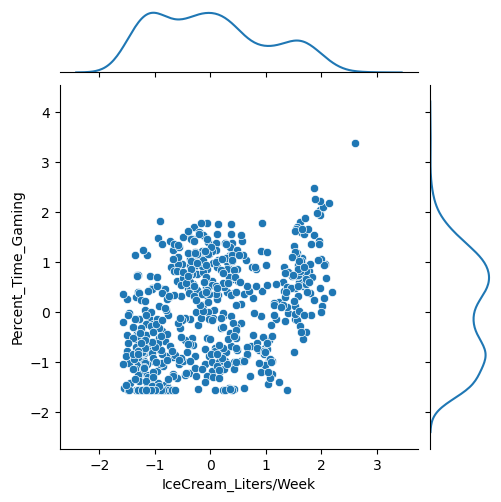

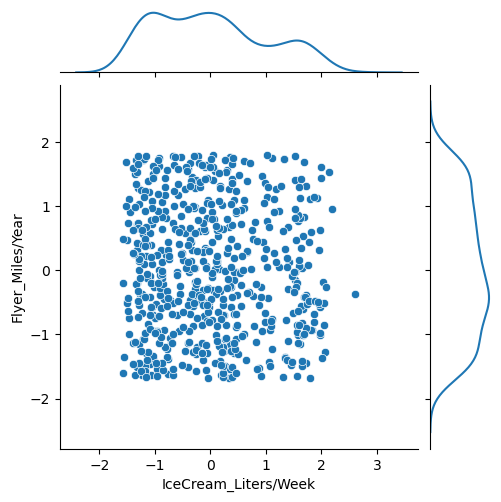

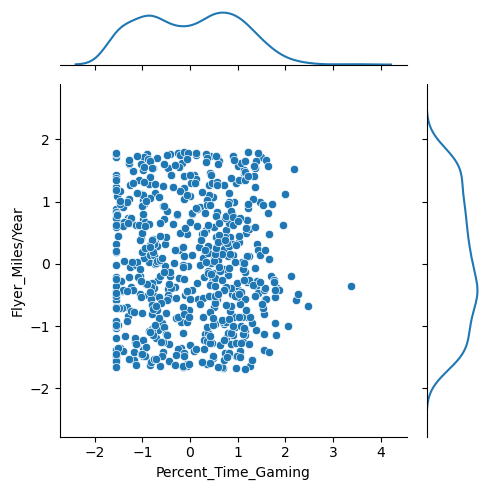

In [135]:
import itertools

for i, p in enumerate(itertools.combinations(cols[-2::-1], r=2)):
    g = sns.JointGrid(x=p[0], y=p[1], data=dating_X)
    g = g.plot(sns.scatterplot, sns.kdeplot)
    g.figure.set_size_inches(5, 5)
    g.set_axis_labels(p[0], p[1])
    g.ax_joint.set_xlim

plt.tight_layout()
plt.show()

### Utility Functions

In [297]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'recall' : make_scorer(recall_score, average='weighted')
    }
def cross_validate_df(X, Y, scoring, model, folds):
    cv_results = pd.DataFrame(cross_validate(model, X, Y, scoring=scoring, cv=folds))
    cv_results = cv_results.iloc[:,2:]
    cv_results.index = np.arange(1, len(cv_results.iloc[:,0])+1)
    cv_results.index.name = 'folds'
    return cv_results
def holdout(X_train, Y_train, X_test, Y_test, model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    performance = pd.DataFrame({
        'accuracy': [accuracy_score(Y_test, Y_pred)],
        'precision': [precision_score(Y_test, Y_pred, average='weighted')],
        'f1-measure': [f1_score(Y_test, Y_pred, average='weighted')],
        'recall': [recall_score(Y_test, Y_pred, average='weighted')]
    })
    return performance

# Naive Bayes Classification (Assuming Gaussian Distribution)
---

Although some correlation can be observed between **gaming time** and **ice cream consumed**, Gaussian Naive Bayes remains a robust classification method due to the roughly normal feature distributions and no correlation between other feature pairs.

In [279]:
gnb = GaussianNB()
NaiveBayesResults = cross_validate_df(dating_X, dating_Y,
                                      scoring='accuracy', model=gnb,
                                      folds=10)
display(NaiveBayesResults.mean())

test_score    0.931667
dtype: float64

# K-NN Classification
---

### Model Selection

- Determining the best value for K

iteration 0 completed.
iteration 10 completed.
iteration 20 completed.
iteration 30 completed.
iteration 40 completed.
iteration 50 completed.
iteration 60 completed.
iteration 70 completed.
iteration 80 completed.
iteration 90 completed.


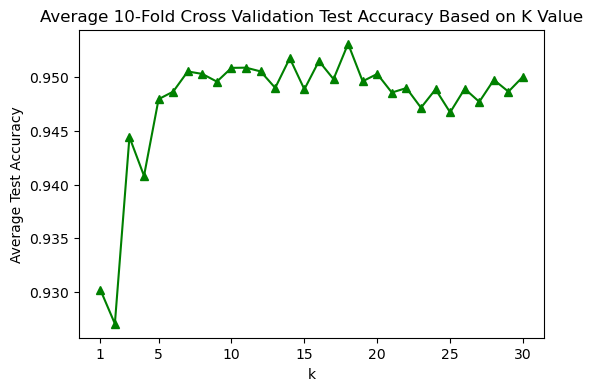

In [252]:
numNeighbors = np.arange(1,31)
testAcc = np.zeros(len(numNeighbors))
iterations = 100
for iteration in range(iterations):
    dating_X, dating_Y = shuffle(dating_X, dating_Y)
    for k in numNeighbors:
        clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
        acc = cross_validate_df(model=clf, X=dating_X,
                                Y=dating_Y, scoring='accuracy', folds=10)
        testAcc[k-1] += acc.mean().iloc[0]
    if (iteration%10 == 0):
        print(f"iteration {iteration} completed.")
testAcc /= iterations    

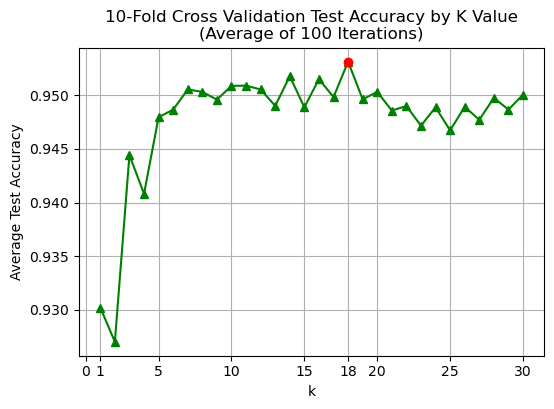

In [296]:
xticks = np.concat([np.array([1]), np.arange(0, 16, 5),
                    np.array([18]), np.arange(20,31,5)])
plt.figure(figsize=(6,4))
plt.plot(np.arange(1,31), testAcc, 'g^-')
plt.scatter(18, testAcc[17], color='red', marker='o', zorder=5)
plt.xlabel('k')
plt.xticks(xticks)
plt.grid()
plt.ylabel('Average Test Accuracy')
plt.title('10-Fold Cross Validation Test Accuracy by K Value\n(Average of 100 Iterations)')
plt.show()

# Decision Tree Classification
---

### Model Selection
- selecting the best impurity measure and maximum tree depth

In [283]:
maxDepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
testAcc_GINI = np.zeros(shape=(len(maxDepths)))
testAcc_ENTROPY = np.zeros(shape=(len(maxDepths)))
repititions = 100
for rep in range(repititions):
    dating_X, dating_Y, shuffle(dating_X, dating_Y)
    for i,d in enumerate(maxDepths):
        clf_GINI = DecisionTreeClassifier(criterion='gini', max_depth=d)
        clf_ENTROPY = DecisionTreeClassifier(criterion='entropy', max_depth=d)
        gini_acc = cross_validate_df(model=clf_GINI, scoring='accuracy', X=dating_X, Y=dating_Y, folds=10)
        entropy_acc = cross_validate_df(model=clf_ENTROPY, scoring='accuracy', X=dating_X, Y=dating_Y, folds=10)
        testAcc_GINI[i] += gini_acc.mean().iloc[0]
        testAcc_ENTROPY[i] += entropy_acc.mean().iloc[0]
    if(rep%10 == 0):
        print(f"repitition {rep} compete")
testAcc_ENTROPY /= repititions
testAcc_GINI /= repititions

repitition 0 compete
repitition 10 compete
repitition 20 compete
repitition 30 compete
repitition 40 compete
repitition 50 compete
repitition 60 compete
repitition 70 compete
repitition 80 compete
repitition 90 compete


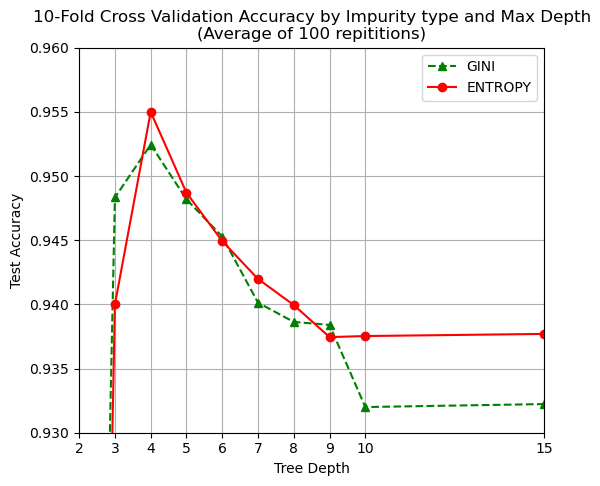

In [294]:
plt.figure(figsize=(6,5))
plt.plot(maxDepths, testAcc_GINI, 'g^--', label="GINI")
plt.plot(maxDepths, testAcc_ENTROPY, 'ro-', label="ENTROPY")
plt.legend()
plt.title('10-Fold Cross Validation Accuracy by Impurity type and Max Depth\n(Average of 100 repititions)')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.xticks(maxDepths)
plt.ylim([0.93,0.96])
plt.xlim([2,15])
plt.grid()
plt.show()

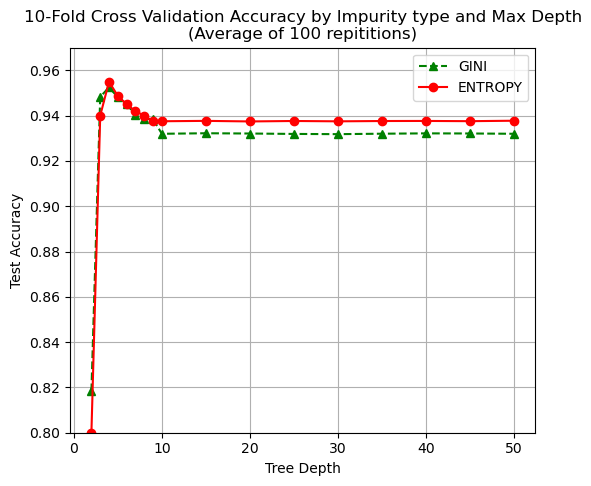

In [295]:
plt.figure(figsize=(6,5))
plt.plot(maxDepths, testAcc_GINI, 'g^--', label="GINI")
plt.plot(maxDepths, testAcc_ENTROPY, 'ro-', label="ENTROPY")
plt.legend()
plt.title('10-Fold Cross Validation Accuracy by Impurity type and Max Depth\n(Average of 100 repititions)')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.ylim([0.8,0.97])
plt.grid()
plt.show()

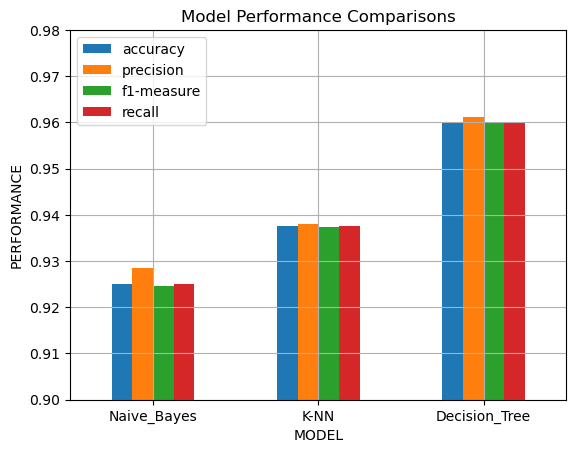

In [311]:
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
k_NN_clf = KNeighborsClassifier(n_neighbors=18, metric='minkowski', p=2)
gnb = GaussianNB()

dt_clf.fit(dating_X, dating_Y)
k_NN_clf.fit(dating_X,dating_Y)
gnb.fit(dating_X, dating_Y)

results = pd.concat([holdout(dating_X, dating_Y, test_dating_X, test_dating_Y, gnb),
                     holdout(dating_X, dating_Y, test_dating_X, test_dating_Y, k_NN_clf),
                     holdout(dating_X, dating_Y, test_dating_X, test_dating_Y, dt_clf)], axis=0)
results.index = ['Naive_Bayes', 'K-NN', 'Decision_Tree']

results.plot(kind='bar', title='Model Performance Comparisons', xlabel='MODEL', ylabel='PERFORMANCE')
plt.xticks(rotation=0)
plt.ylim([0.9,0.98])
plt.grid()
plt.show()